# Fit an LSTM to a subsample of the linear song->female motion dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from disp import set_plot

cc = np.concatenate

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

2022-12-22 13:09:03.692478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load data
df_behav = pd.read_csv('data/simple/ann/c_song_f_behav_lin.csv')
dfs_tr = [df_behav[df_behav.ID == i] for i in ISTRAIN]
df_behav = None

In [4]:
ITR_XPL = 0
TARG_XPL = TARGS[1]

df_tr = dfs_tr[ITR_XPL]

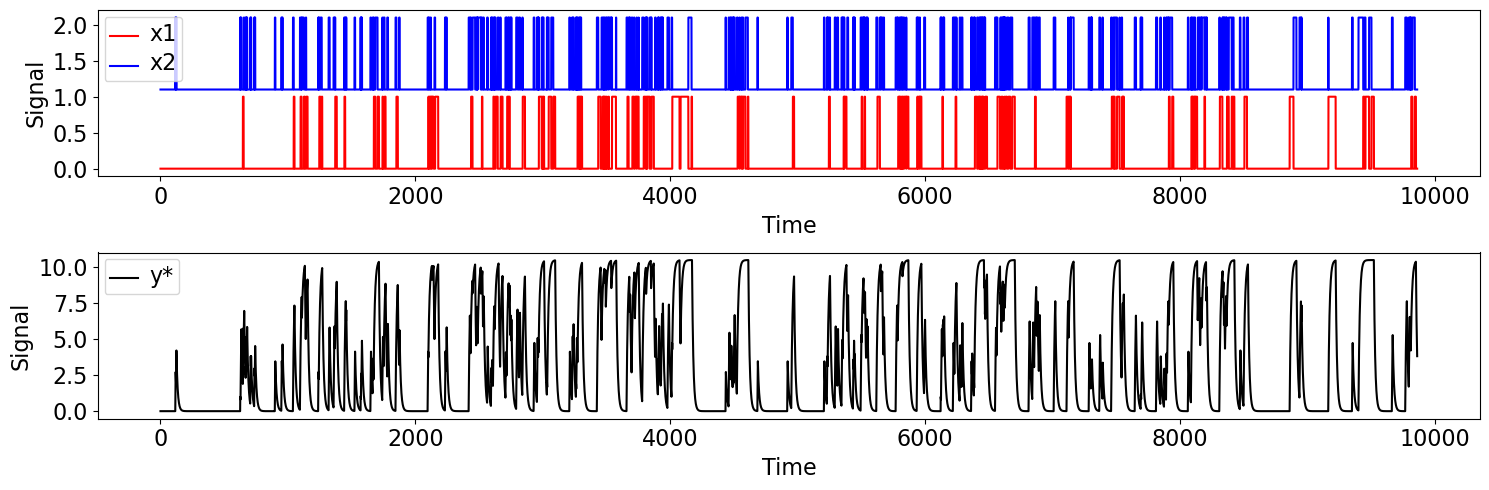

In [5]:
x1 = np.array(df_tr['S'])
x2 = np.array(df_tr['P'])
# y = np.array(df_tr[TARG_XPL])
h = np.exp(-np.arange(100)/10)
y = signal.fftconvolve(x1, h)[:len(x1)] + signal.fftconvolve(x2, h)[:len(x2)]

fig, axs = plt.subplots(2, 1, figsize=(15, 5), tight_layout=True)
axs[0].plot(x1, c='r')
axs[0].plot(x2+1.1, c='b')
axs[0].legend(['x1', 'x2'])

axs[1].plot(y, c='k')
axs[1].legend(['y*', 'y'])

for ax in axs:
    set_plot(ax, x_label='Time', y_label='Signal', font_size=16)

In [6]:
look_back = 100

In [7]:
x = np.nan*np.zeros((len(y)-look_back, look_back, 2))
for t in range(look_back, len(y)):
    x[t-look_back, :, 0] = x1[t-look_back:t]
    x[t-look_back, :, 1] = x2[t-look_back:t]

In [8]:
ptrain = .8
ntrain = int(round(.8*len(x)))
ntest = len(x) - ntrain

x_train = x[:ntrain, :]
x_test = x[ntrain:,:]
y_train = y[look_back:look_back+ntrain]
y_test = y[look_back+ntrain:]

In [9]:
# design network
input_shape = (x_train.shape[1], x_train.shape[2])  # num timesteps x num features

2022-12-22 13:09:09.911529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
109/109 - 10s - loss: 2.8720 - val_loss: 2.8093 - 10s/epoch - 95ms/step
Epoch 2/50
109/109 - 8s - loss: 2.0758 - val_loss: 2.2150 - 8s/epoch - 70ms/step
Epoch 3/50
109/109 - 7s - loss: 1.5157 - val_loss: 0.6304 - 7s/epoch - 65ms/step
Epoch 4/50
109/109 - 10s - loss: 0.5001 - val_loss: 0.4182 - 10s/epoch - 87ms/step
Epoch 5/50
109/109 - 9s - loss: 0.4379 - val_loss: 0.5894 - 9s/epoch - 80ms/step
Epoch 6/50
109/109 - 10s - loss: 0.3655 - val_loss: 0.1825 - 10s/epoch - 93ms/step
Epoch 7/50
109/109 - 12s - loss: 0.2847 - val_loss: 0.2560 - 12s/epoch - 110ms/step
Epoch 8/50
109/109 - 13s - loss: 0.2900 - val_loss: 0.1280 - 13s/epoch - 119ms/step
Epoch 9/50
109/109 - 11s - loss: 0.2102 - val_loss: 0.2198 - 11s/epoch - 101ms/step
Epoch 10/50
109/109 - 12s - loss: 0.1900 - val_loss: 0.1494 - 12s/epoch - 109ms/step
Epoch 11/50
109/109 - 13s - loss: 0.2570 - val_loss: 0.1972 - 13s/epoch - 121ms/step
Epoch 12/50
109/109 - 12s - loss: 0.2312 - val_loss: 0.2977 - 12s/epoch - 113ms/step
E

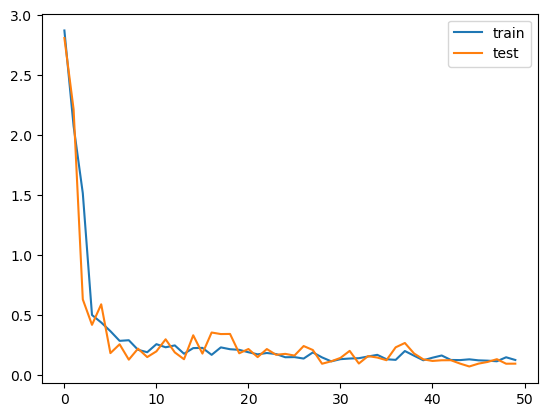

In [10]:
model = Sequential()
model.add(LSTM(100, input_shape=input_shape))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate=.01)
model.compile(loss='mae', optimizer=optimizer)

# fit network
history = model.fit(x_train, y_train, epochs=50, batch_size=72, validation_data=(x_test, y_test), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

62/62 [==============================] - 4s 59ms/step


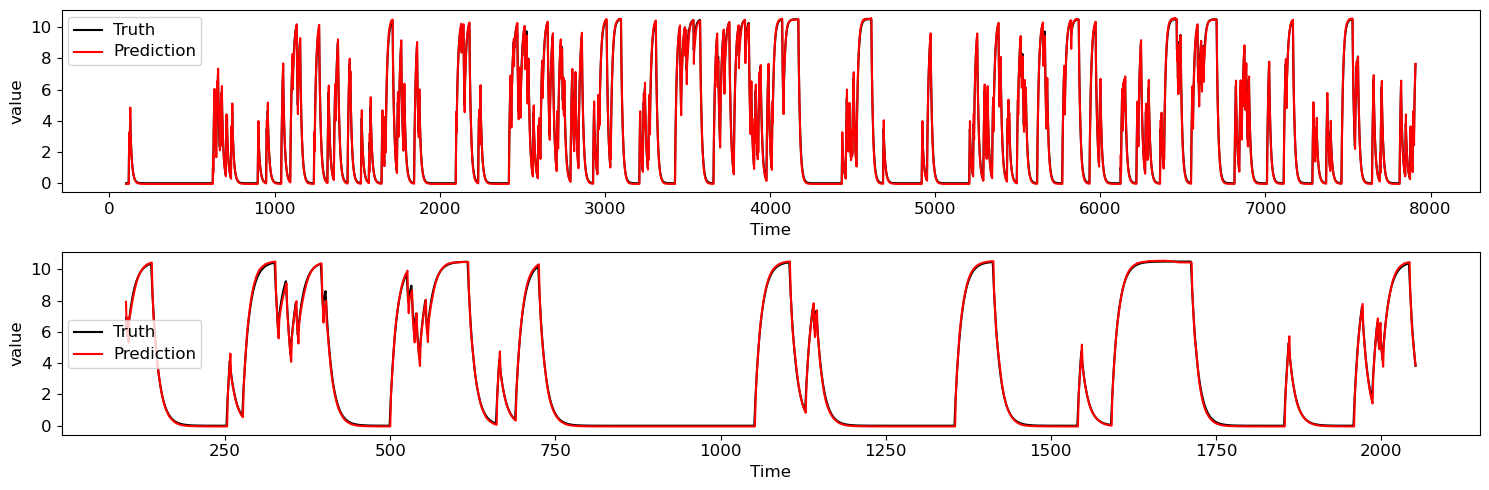

In [11]:
y_hat_train = model.predict(x_train)
y_hat_test = model.predict(x_test)

fig, axs = plt.subplots(2, 1, figsize=(15, 5), tight_layout=True)
axs[0].plot(look_back+np.arange(ntrain), y_train, c='k')
axs[0].plot(look_back+np.arange(ntrain), y_hat_train, c='r')

axs[1].plot(look_back+np.arange(ntest), y_test, c='k')
axs[1].plot(look_back+np.arange(ntest), y_hat_test, c='r')

for ax in axs:
    ax.legend(['Truth', 'Prediction'])
    set_plot(ax, x_label='Time', y_label='value', font_size=12)